In [1]:
%matplotlib inline

In [2]:
from boilerplate import *
import os, sys
import functional_vectorizer
from dio import dataio
from scipy import fftpack, signal, special
from imp import reload
style.use('dark_background')

In [19]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianDropout, GaussianNoise, Reshape
from keras.layers import LSTM, Lambda
from keras.layers.convolutional import Convolution1D, Convolution2D, AtrousConvolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import regularizers
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
# data = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_X.npy')
# data = np.load('/home/mike/ve/ml/vec_sampen_9598_376.npy')
# Y = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_Y.npy')
data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_mh_ftfc_9583_566')
data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_mh_ftfc_9648_087')
files1 = pd.read_csv('/home/mike/ve/ml/vec_mh_ftfc_9583_566_name.csv')
files2 = pd.read_csv('/home/mike/ve/ml/vec_mh_ftfc_9648_087_name.csv')

In [5]:
# data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9598_376')
# data_t, Y_t = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9607_384')
# files1 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9598_376_name.csv')
# files2 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9607_384_name.csv')

In [6]:
data_all = np.concatenate([data, data_t], axis=0)
Y_all = np.concatenate([Y, Y_t ], axis=0)
files_all = pd.concat([files1, files2], axis=0)

In [7]:
print(data.shape, Y.shape, files_all.shape, np.mean(Y, axis=0))

((5970, 1024), (5970, 1), (7858, 2), array([ 0.07269682]))


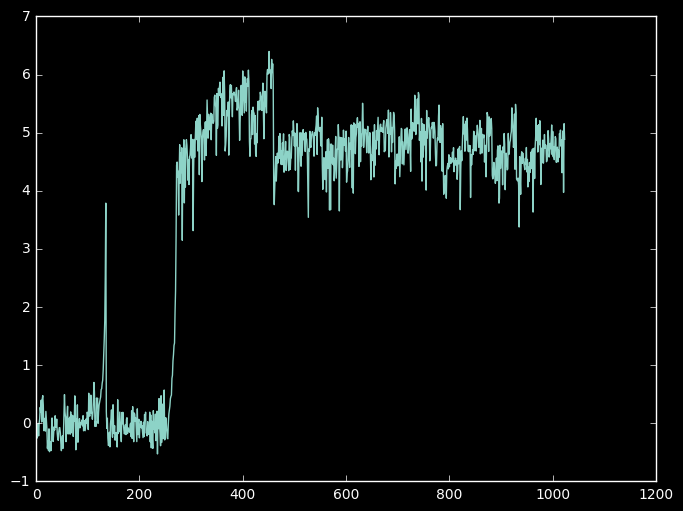

In [20]:
plot(data[0])

In [8]:
# files.to_csv('vec_enc_lf256_16_each_label_names.csv')

In [13]:
def deepclass0(ds_shape):
    n_input_len=ds_shape[1]
    model = Sequential()
    model.add(Convolution1D(nb_filter=64, filter_length=8, input_dim=1, 
                            input_length=n_input_len, border_mode='same', activation='relu'))
    model.add(MaxPooling1D(pool_length=2))
    model.add(LSTM(100))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

In [29]:
def shallowclass1(ds_shape, compression_factor=32, input_noise=0.2, dropout_p=0.5, activ='tanh', final_activ='sigmoid'):
# compression_factor=20
    print('DS shape: {}'.format(ds_shape))
    in_dims = ds_shape[1]
    encoding_dim = int(in_dims//compression_factor)
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, ds_shape, encoding_dim))
 
    model = Sequential()
    model.add(GaussianNoise(input_noise, input_shape=(in_dims,)))
    model.add(Dense(in_dims//compression_factor, activation=activ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_p)) 
    print(model.layers[-1].output_shape)

    model.add(Dense(encoding_dim*2, activation=activ))
    model.add(Dropout(dropout_p))
    model.add(Dense(1, activation=final_activ))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.model_name = 'Deep Classifier 1'
    return model
    
c1 = shallowclass1(data.shape, activ='tanh', final_activ='relu')
print(c1.summary())

DS shape: (5970, 1024)
Input Dims: 1024, input shape: (5970, 1024), encoding dims: 32
(None, 32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gaussiannoise_9 (GaussianNoise)  (None, 1024)          0           gaussiannoise_input_9[0][0]      
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 32)            32800       gaussiannoise_9[0][0]            
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorma(None, 32)            64          dense_22[0][0]                   
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 32)            0           batchnormalization_10[0][0] 

In [13]:
def deepclass1(ds_shape, compression_factor=8, input_noise=0.2, dropout_p=0.5, activ='tanh', final_activ='sigmoid'):
# compression_factor=20
    print('DS shape: {}'.format(ds_shape))
    in_dims = ds_shape[1]
    encoding_dim = int(in_dims//compression_factor)
    print('Input Dims: {}, input shape: {}, encoding dims: {}'.format(in_dims, ds_shape, encoding_dim))
    
    ndim_conv = 64
    # this is our input placeholder
    model = Sequential()
#     model.add(Input(shape=(in_dims,)))
    model.add(GaussianNoise(input_noise, input_shape=(in_dims,)))
#     model.add(Reshape((in_dims,1)))
#     model.add(AtrousConvolution1D(nb_filter=ndim_conv, filter_length=8, border_mode='same', input_dim=1, activation='relu'))
#     model.add(MaxPooling1D(pool_length=2))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_p)) 
    print(model.layers[-1].output_shape)
#     model.add(Reshape((ndim_conv*128,))) # I have no idea why this got bigger
#     model.add(Dense(encoding_dim*4, activation=activ, activity_regularizer=regularizers.activity_l1(10e-5)))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_p)) #batch norm before dropout
    model.add(Dense(encoding_dim*2, activation=activ))
    model.add(Dropout(dropout_p))

    model.add(Dense(encoding_dim, activation=activ))
    model.add(Dropout(dropout_p))

    # Middle Noise
#     encoded = GaussianNoise(0.02)(encoded)

    model.add(Dense(1, activation=final_activ))
    
    #MODEL
    classifier = model# = Model(input=input_img, output=decoded)

#     model.add(GaussianNoise(0.1), input_shape=(n_input_len,))
#     classifier.compile(optimizer='adadelta', loss='binary_crossentropy')
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    classifier.model_name = 'Deep Classifier 1'
    return classifier
    
dc1 = deepclass1(data.shape, activ='tanh', final_activ='tanh')
print(dc1.summary())

DS shape: (5970, 1024)
Input Dims: 1024, input shape: (5970, 1024), encoding dims: 128
(None, 1024)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gaussiannoise_3 (GaussianNoise)  (None, 1024)          0           gaussiannoise_input_3[0][0]      
____________________________________________________________________________________________________
batchnormalization_4 (BatchNormal(None, 1024)          2048        gaussiannoise_3[0][0]            
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 1024)          0           batchnormalization_4[0][0]       
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 256)           262400      dropout_6[0][0]          

# Training the Classifier

In [30]:
x,y = dataio.subdiv_and_shuffle(data, Y, resample='up', shuffle=True) # let keras shuffle
print(x.shape, y.shape, np.mean(y, axis=0))

new set:  (11178, 1024)
label shapes:  (5536, 1) (5642, 1) 11178
((11178, 1024), (11178, 1), array([ 0.50474146]))


In [40]:
x_train = x
y_train = y
dc1.fit(x_train, y_train, batch_size=256,shuffle=True,#validation_split=.1,
        validation_data=(x, y),
                nb_epoch=10)

Train on 11178 samples, validate on 11178 samples
Epoch 1/10
11178/11178 [==============================] - 1s - loss: 4.1860 - acc: 0.3476 - val_loss: 3.4843 - val_acc: 0.4147
Epoch 2/10
11178/11178 [==============================] - 1s - loss: 3.6083 - acc: 0.3867 - val_loss: 2.4759 - val_acc: 0.5117
Epoch 3/10
11178/11178 [==============================] - 1s - loss: 3.1132 - acc: 0.4266 - val_loss: 1.5518 - val_acc: 0.5501
Epoch 4/10
11178/11178 [==============================] - 1s - loss: 2.9159 - acc: 0.4372 - val_loss: 0.8811 - val_acc: 0.6350
Epoch 5/10
11178/11178 [==============================] - 1s - loss: 2.8282 - acc: 0.4497 - val_loss: 1.8214 - val_acc: 0.5369
Epoch 6/10
11178/11178 [==============================] - 1s - loss: 2.5468 - acc: 0.4650 - val_loss: 1.0997 - val_acc: 0.5976
Epoch 7/10
11178/11178 [==============================] - 1s - loss: 2.8872 - acc: 0.4498 - val_loss: 2.4021 - val_acc: 0.4932
Epoch 8/10
11178/11178 [==============================] - 1s 

In [38]:
pr = c1.predict_classes(x_train)
print('')
print(np.sum(pr), pr.shape, np.sum(pr)*1./len(pr), np.mean(pr == 1))

11168/11178 [============================>.] - ETA: 0s
(1, (11178, 1), 8.9461442118446945e-05, 8.9461442118446945e-05)


In [ ]:
prp = 

In [36]:
pr

array([[1],
       [0],
       [1],
       ..., 
       [0],
       [0],
       [0]], dtype=int32)

In [37]:
np.mean(pr == y[:,0]) # MOMENT OF TRUUUUUTH!!!!!!

0.49687041818238104

In [49]:
y_train[:,0]

array([ 1.,  1.,  1., ...,  0.,  1.,  1.])

In [83]:
np.mean(y_train[:,0]==1)

0.51071834806194771

In [20]:
pr = model.predict_classes(X_train)

NameError: name 'model' is not defined

In [ ]:
np.sum(pr)

In [ ]:
pr.shape